# Quantum State Preparation

Given a $2^n$-dimensional state vector $\psi=\sum_{x=0}^{2^n-1}\psi_x\ket{x}_n\in\mathbb{C}^{2^n}$ such that $\|\psi\|_2=1$, we write a function QSP $(\psi)$ which outputs a circuit $U$, such that 
$$U\ket{0}_n=\sum_{x=0}^{2^n-1}\psi_x\ket{x}_n\ .$$

The construction is done in three steps. 
1. Using the absolute values $|\psi_x|$, find angles $\theta, \theta_{0}, \theta_{1}, \theta_{00}, \theta_{10}, \theta_{01}, \theta_{11}, \cdots $ such that (for example in the case of $n=3$) 
$$\sum_{x=0}^{2^3-1}|\psi_x|\ket{x}_n=\cos(\theta/2)\bigg(\cos(\theta_{0}/2)\Big(\cos(\theta_{00}/2)\ket{0}+\sin(\theta_{00}/2)\ket{1}\Big)\ket{0}+\sin(\theta_{0}/2)\Big(\cos(\theta_{10}/2)\ket{0}+\sin(\theta_{10}/2)\ket{1}\Big)\ket{1}\bigg)\ket{0}$$
$$\qquad\qquad\qquad + \sin(\theta/2)\bigg(\cos(\theta_{1}/2)\Big(\cos(\theta_{01}/2)\ket{0}+\sin(\theta_{01}/2)\ket{1}\Big)\ket{0}+\sin(\theta_{1}/2)\Big(\cos(\theta_{11}/2)\ket{0}+\sin(\theta_{11}/2)\ket{1}\Big)\ket{1}\bigg)\ket{1}.$$ 
$\quad\ \ $ This step is entirely classical.

2. Using the $R_Y$ multiplexers and the angles obtained in step 1, prepare the state $\sum_{x=0}^{2^n-1}|\psi_x|\ket{x}_n$.

3. Using the $R_Z$ multiplexers and one ancilla, prepare the state $\sum_{x=0}^{2^n-1}\psi_x\ket{x}_n$ from the state $\sum_{x=0}^{2^n-1}|\psi_x|\ket{x}_n$.

In [284]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector

import numpy as np

## Step 1 - Find the angles $\theta_{\dots}$ from absoute values $|\psi_x|$

The function 'theta_amp (amps)' takes an array of absolute values $|\psi_0|, |\psi_1|, \cdots |\psi_{2^n-1}|$ as input and returns the angle 
$$\theta = 2\cos^{-1}\bigg(\frac{\sqrt{|\psi_0|^2+|\psi_1|^2+\cdots+|\psi_{2^{n-1}-1}|^2}}{\sqrt{|\psi_0|^2+|\psi_1|^2+\cdots+|\psi_{2^{n}-1}|^2}}\bigg)\ .$$
If the denominator is zero then the angle 0 is returned. 

Essentially we take twice of $\arccos$ of the ratio of norm of first half of an input vector by the norm of the input vector itself.

In [82]:
def theta_amp (amps):
    sub_amps = np.split(amps, 2)
    norm_amps = np.linalg.norm(amps)
    if norm_amps == 0:
        return 0
    return 2*np.arccos(np.linalg.norm(sub_amps[0])/norm_amps)

The function 'amp_to_ang(amps)' takes the absolute values $|\psi_x|$ as input and outputs the list of angles $\theta, \theta_{0}, \theta_{1}, \theta_{00}, \theta_{10}, \theta_{01}, \theta_{11}, \cdots $, in that order.

In [ ]:
def amp_to_ang (amps):
    n = int(np.log2(len(amps)))
    angs = [theta_amp(amps)]
    for i in range(1, n): # at the i-th step split the input vector into 2^i equal parts
        sub_amps = np.split(amps, 1<<i)
        for x in sub_amps: # for every splitted vector find angle theta
            angs.append(theta_amp(x)) 
    return angs

## Step 2 - Prepare the absolute value state using $R_Y$ multiplxers

We first create a multi-controleld $R_Z$ gate. This is exactly same the qiskit in-built mcrz gate. The only utility of the following function is to better display the subsequent circuits by avoiding the decomposition of mcrz qiskit implementation.

In [230]:
def MCRZ (n, theta):
    reg = QuantumRegister(n, name='x')
    circ = QuantumCircuit(reg, name='MC'+r'$R_Z$'+'('+str(np.round(theta, 2))+')')
    circ.mcrz(theta, reg[1:], reg[0])
    return circ.to_gate()

### The $R_Y$ multiplexer

The following function 'ry_mux(n, theta, state)' implement an $R_Y$-gate multiplexer on $n$ qubits. 

1. The first qubit is the target qubit, while the last $n-1$ qubits are control qubits. 

2. The angle of rotation of $R_Y$ gate in the target qubit is specified by theta. 

3. The input variable 'state' specifies the control state. 
For example, when state = '110', the target qubit $x_0$ will be tranformed by $R_Y$ iff $x_1=1$, $x_2=1$, $x_3=0$.

Given $n$, state has to be a bitstring of length $n-1$.

Note that only $1$-qubit gates and the multi-controleld $R_Z$ gate are used in its implementation, using the simple identity 
$$R_Y(\theta) = P(\pi/2)\,H\,R_Z(\theta)\,H\,P(-\pi/2)\ .$$

In [ ]:
def ry_mux (n, theta, state):
    reg = QuantumRegister(n, name='x')
    circ = QuantumCircuit(reg, name='m'+r'$R_Y$'+'\n'+str(state)+'\n'+r'$\theta$'+ '='+str(np.round(theta, 2)))
    qbs = [reg[k+1] for k, x in enumerate(state) if x == '0']
    if len(qbs) != 0:
        circ.x(qbs) # flip the bits that are 0
    circ.p(-np.pi/2, reg[0])
    circ.h(reg[0])
    circ.compose(MCRZ(n, theta), inplace=True)
    circ.h(reg[0])
    circ.p(np.pi/2, reg[0])
    if len(qbs) != 0:
        circ.x(qbs) # flip the bits back
    return circ.to_gate()

The following code displays a circuit diagram of the $R_Y$-multiplexer implemented above. 

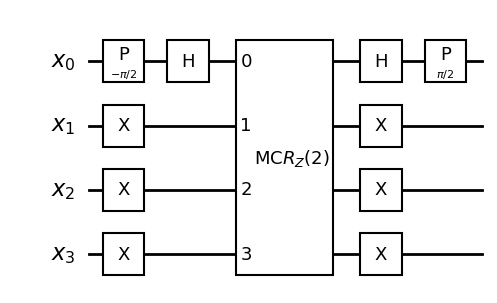

In [ ]:
n = 4 # the number of qubits
theta = 2 # the angle of rotation
state = '000' # the control state
qr = QuantumRegister(n, name='x')
qc = QuantumCircuit(qr, name='Ry multiplixer')
qc.compose(ry_mux(n, theta, state), inplace=True)
qc.decompose().draw(output='mpl', style='bw')

### The absolute value state preparation 

The following function returns a quantum circuit that prepares the state $\sum_{x=0}^{2^n-1}|\psi_x|\ket{x}$. 

The second input 'angs' is the angles $\theta, \theta_{0}, \theta_{1}, \theta_{00}, \theta_{10}, \theta_{01}, \theta_{11}, \cdots $. 

In [105]:
def q_amp_prep (n, angs):
    reg = QuantumRegister(n, name='x')
    circ = QuantumCircuit(reg, name='amp_prep')
    circ.ry(angs[0], reg[-1])
    for i in range(1, n):
        for j in range(0, (1<<i)):
            bij = format(j, f'0{i}b')[::-1]
            circ.compose(ry_mux(i+1, angs[(1<<i)+j-1], bij), qubits=reg[-i-1:], inplace=True)
    return circ.to_gate()

The following code illustrates the 'q_amp_prep' function for 
$$\psi=\frac{1}{\sqrt{204}}\ket{000}+\frac{2}{\sqrt{204}}\ket{100}+\frac{3}{\sqrt{204}}\ket{010}+\frac{4}{\sqrt{204}}\ket{110}+\frac{5}{\sqrt{204}}\ket{001}+\frac{6}{\sqrt{204}}\ket{101}+\frac{7}{\sqrt{204}}\ket{011}+\frac{8}{\sqrt{204}}\ket{111}.$$

The number displayed in the output (above the ciruit diagram) is the error (square norm of the difference) between the input vector $\psi$ and the statevector of the ciruit.

1.126243234769772e-15


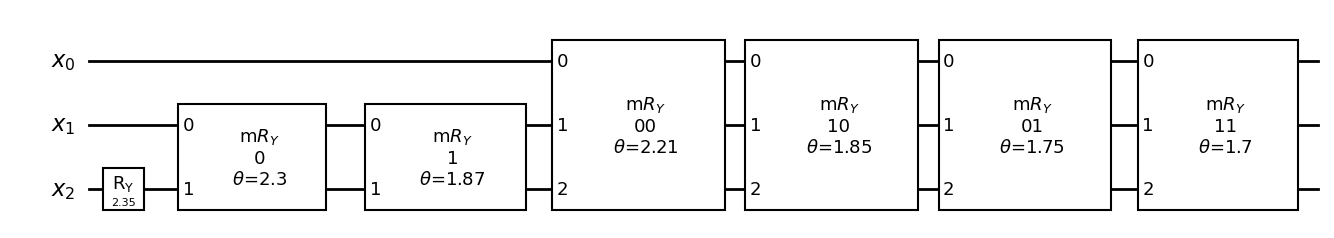

In [ ]:
n = 3
psi = np.arange(1, 1+(1<<n))
psi = (1/np.linalg.norm(psi))*psi
qx = QuantumRegister(n, name='x')
qsp = QuantumCircuit(qx)
angs = amp_to_ang(psi) # get the angles from the psi
qsp.compose(q_amp_prep(n, angs), inplace=True) # use the angles obtained as second input in q_amp_prep function
print(np.linalg.norm(np.array(Statevector(qsp))-psi)) # display the error between statevector and the given vector
qsp.decompose().draw(output='mpl', style='bw')

## Step 3 - Prepare the angles $\arg(\psi_x)$ using $R_Z$ multiplexers

### The $R_Z$ multiplexer

The following function 'rz_mux(n, theta, state)' implement an $R_Z$-gate multiplexer on $n+1$ qubits. 

1. The last (ancilla) qubit is the target qubit, while the first $n$ qubits are control qubits. 

2. The angle of rotation of $R_Z$ gate in the target qubit is specified by theta. 

3. The input variable 'state' specifies the control state. 
For example, when state = '001', the target qubit $a$ will be tranformed by $R_Z$ iff $x_0=0$, $x_1=0$, $x_2=1$.

Given $n$, state has to be a bitstring of length $n$.

In [ ]:
def rz_mux (n, theta, state):
    reg = QuantumRegister(n, name='x')
    anc = AncillaRegister(1, name='a')
    circ = QuantumCircuit(reg, anc, name='m'+r'$R_Z$'+'\n'+str(state)+'\n'+r'$\theta$'+ '='+str(np.round(theta, 2)))
    qbs = [reg[k] for k, x in enumerate(state) if x == '0']
    if len(qbs) != 0:
        circ.x(qbs) # flip the bits that are 0
    circ.compose(MCRZ(n+1, 2*theta), qubits=reversed(reg[:]+[anc[0]]), inplace=True)
    if len(qbs) != 0:
        circ.x(qbs) # flip the bits back
    return circ.to_gate()

The following code displays a circuit diagram of the $R_Z$-multiplxer implemented above. 

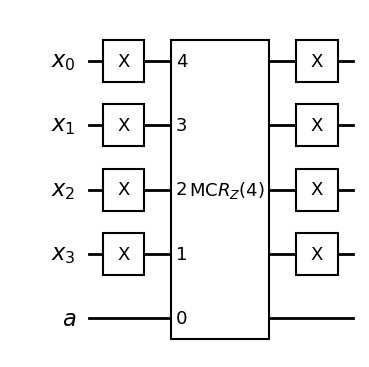

In [ ]:
n = 4 # the number of qubits
theta = 2 # the angle of rotation
state = '0000' # the control state
qr = QuantumRegister(n, name='x')
qa = AncillaRegister(1, name='a')
qc = QuantumCircuit(qr, qa, name='Rz multiplixer')
qc.compose(rz_mux(n, theta, state), inplace=True)
qc.decompose().draw(output='mpl', style='bw')

### The argument preparation circuit

Given the number of qubits $n$ and a list of $2^n$ angles $\theta_x$ ('args'), the following function returns a ciruit that shifts the phase of the $\ket{x}$ by $\theta_x$.

It makes use of the $R_Z$-multiplexer implemented above. The ancilla qubit is first flipped to $\ket{1}$ and then depending on the state $\ket{x}$ of the quantum register, the phase $\theta_x$ is recorded using the ancilla register. Finally, the ancilla register is flipped back to $\ket{0}$.

In [264]:
def q_arg_prep (n, args):
    reg = QuantumRegister(n, name='x')
    anc = AncillaRegister(1, name='a')
    circ = QuantumCircuit(reg, anc, name='arg_prep')
    circ.x(anc)
    for i in range(1<<n):
        bi = format(i, f'0{n}b')[::-1]
        circ.compose(rz_mux(n, args[i], bi), qubits=reg[:]+[anc[0]], inplace=True)
    circ.x(anc)
    return circ.to_gate()

The following code illustrates the 'q_arg_prep' function for a random list of $2^n$ angles between $-\pi$ to $\pi$.

The list of angles is displayed in the output along with the ciruit diagram.

[ 1.74026477 -2.8985433  -0.87256805  0.29860592]


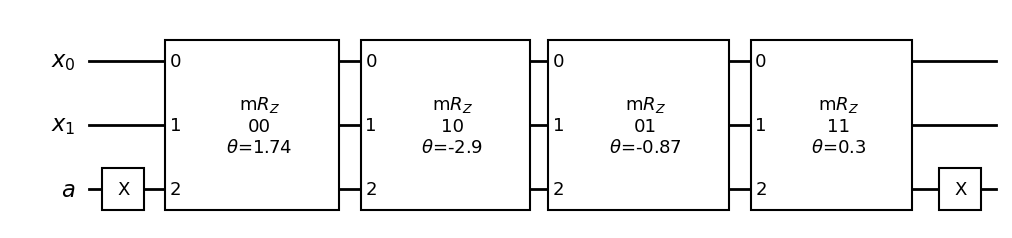

In [265]:
n = 2
args = np.random.uniform(-np.pi, np.pi, 1<<n)
qx = QuantumRegister(n, name='x')
qa = AncillaRegister(1, name='a')
qsp = QuantumCircuit(qx, qa)
qsp.compose(q_arg_prep(n, args), inplace=True)
print(args)
qsp.decompose().draw(output='mpl', style='bw')

## The final quantum state preparation circuit

The quantum state preparation circuit is essentially a composition of the absolute value state prepration circuit and the argument prepation circuit.

### Generate random complex unit vectors for testing

Given $n$, the following function generates a $2^n$-dimensional complex vector of norm $1$.

In [286]:
def gen_psi (n):
    max_mod = 10 # can be changed to any other positive number
    rand_amps = np.random.uniform(0, max_mod, 1<<n)
    rand_args = np.random.uniform(-np.pi, np.pi, 1<<n)
    rand_psi = rand_amps*np.exp(1.j*rand_args)
    norm_psi = np.linalg.norm(rand_psi)
    if norm_psi != 0:
        return (1/norm_psi)*rand_psi
    return gen_psi(n)

### The final quantum state preparation circuit

Given a $2^n$-dimensional unit complex vector $\psi$, the following function output a circuit whose statevector is the given vector $\psi$.

In [288]:
def QSP (psi):
    psi_amps = np.absolute(psi) # find the moduli of components of psi
    psi_args = np.angle(psi) # find the arguments of components of psi
    qx = QuantumRegister(n, name='x')
    qa = AncillaRegister(1, name='a')
    qsp = QuantumCircuit(qx, qa, name='QSP')
    angs = amp_to_ang(psi_amps) # find the list of thetas associated to moduli of components of psi
    qsp.compose(q_amp_prep(n, angs), qubits=qx, inplace=True) # prepare the absolute value state
    qsp.compose(q_arg_prep(n, psi_args), inplace=True) # load the agruments
    return qsp

### Testing on randomly generated complex unit vectors

The following code illustrates the QSP circuit implemented above for randomly generated unit complex vector of dimenstion $2^n$.

The number displayed in the output (above the ciruit diagram) is the error (square norm of the difference) between the input vector $\psi$ and the statevector of the ciruit.

1.9366010342907562e-15


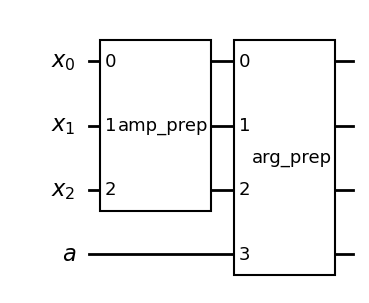

In [289]:
n = 3
psi = gen_psi(n)
qx = QuantumRegister(n, name='x')
qa = AncillaRegister(1, name='a')
qsp = QuantumCircuit(qx, qa, name='QSP')
qsp.compose(QSP(psi), inplace=True)
print(np.linalg.norm(np.array(Statevector(qsp))[:1<<n]-psi))
qsp.draw(output='mpl', style='bw')

In [290]:
psi

array([ 0.31293768+0.32695403j,  0.05207757+0.00593108j,
        0.1614727 +0.14555888j,  0.07238078+0.68598084j,
       -0.22927037-0.05507288j, -0.02800363+0.03685824j,
       -0.02514627-0.14733904j,  0.42689247+0.08387692j])

In [291]:
Statevector(qsp).draw("latex")

<IPython.core.display.Latex object>